In [1]:
import os

import pandas as pd
from aif360.sklearn.datasets import fetch_german
from sklearn.preprocessing import LabelEncoder

if not os.path.exists(os.path.join("..", "data")):
    os.mkdir(os.path.join("..", "data"))

if not os.path.exists(os.path.join("..", "data", "german_credit")):
    os.mkdir(os.path.join("..", "data", "german_credit"))

print("Fetching German Credit dataset...")
dataset = fetch_german()

pip install 'aif360[LawSchoolGPA]'


Fetching German Credit dataset...


/home/dhasade/.local/lib/python3.8/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [2]:
# split into inputs and outputs

X, y = dataset.X, dataset.y

In [3]:
X.marital_status.unique()

['single', 'div/dep/mar', 'div/sep', 'mar/wid']
Categories (4, object): ['div/dep/mar', 'div/sep', 'mar/wid', 'single']

In [4]:
X.own_telephone.unique()

['yes', 'none']
Categories (2, object): ['none', 'yes']

In [5]:
X.sex.unique()

['male', 'female']
Categories (2, object): ['female' < 'male']

In [6]:
X.age.unique()

array([67., 22., 49., 45., 53., 35., 61., 28., 25., 24., 60., 32., 44.,
       31., 48., 26., 36., 39., 42., 34., 63., 27., 30., 57., 33., 37.,
       58., 23., 29., 52., 50., 46., 51., 41., 40., 66., 47., 56., 54.,
       20., 21., 38., 70., 65., 74., 68., 43., 55., 64., 75., 19., 62.,
       59.])

<Axes: >

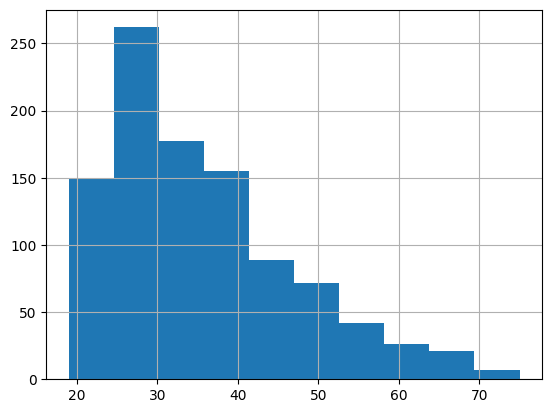

In [7]:
# plot histogram of age
X.age.hist()

In [8]:
X.employment.unique()

['>=7', '1<=X<4', '4<=X<7', 'unemployed', '<1']
Categories (5, object): ['1<=X<4', '4<=X<7', '<1', '>=7', 'unemployed']

<Axes: >

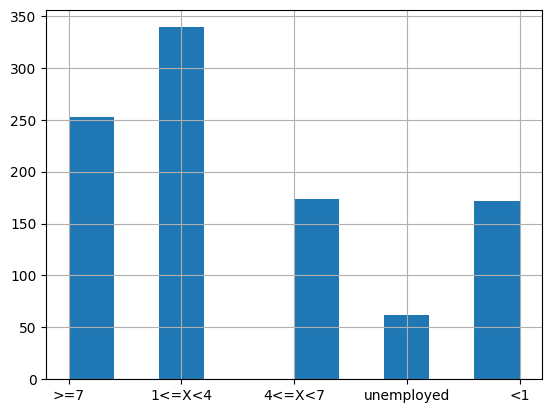

In [9]:
X.employment.hist()

In [10]:
attributes = ['employment', 'marital_status', 'own_telephone', 'sex']

# encode categorical variables
le = LabelEncoder()
for attr in attributes:
    X[attr] = le.fit_transform(X[attr])

In [15]:
# encode age as a categorical variable into 3 bins: < 25, 25-50, > 50
X['age'] = pd.cut(X['age'], bins=[0, 25, 50, 100], labels=[0, 1, 2])

In [19]:
X = X.reset_index(drop=True)
# X.to_csv(os.path.join("..", "data", "german_credit", "ma_features.csv"), index=False)

In [20]:
y = LabelEncoder().fit_transform(y)
y = pd.DataFrame(y)
y = y.rename(columns={0: "Y"})
# y.to_csv(os.path.join("..", "data", "german_credit", "ma_labels.csv"), index=False)

## ------------- Compute strata sizes -------------

In [29]:
def get_sum_value(nested_dict):
    sum_value = 0
    for _, v in nested_dict.items():
        if isinstance(v, dict):
            v = get_sum_value(v)
        sum_value += v
    return sum_value

def get_max_value(nested_dict):
    max_value = 0
    for _, v in nested_dict.items():
        if isinstance(v, dict):
            v = get_max_value(v)
        if v > max_value:
            max_value = v
    return max_value

In [2]:
X_path = os.path.join("..", "data", "german_credit", "ma_features.csv")
y_path = os.path.join("..", "data", "german_credit", "ma_labels.csv")

# read in the data
X = pd.read_csv(X_path)
y = pd.read_csv(y_path)

In [4]:
protected_attributes = ['employment', 'marital_status', 'own_telephone', 'sex', 'age']
possible_values = [len(X[attr].unique()) for attr in protected_attributes]
value_sets = [set(range(possible_values[i])) for i in range(len(possible_values))]

In [67]:
possible_values

[5, 4, 2, 2, 3]

In [39]:
from itertools import combinations, product
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [36]:
features = X
labels = y
n = len(protected_attributes)

all_probs = dict()
all_ys = dict()
all_nks = dict()

for base_agent in range(n): # Base agent
    print(f'Working on base agent {base_agent}')
    base_attr = protected_attributes[base_agent]
    possible_collaborators = [i for i in range(n) if i != base_agent]
    all_probs[base_agent] = dict()
    all_ys[base_agent] = dict()
    all_nks[base_agent] = dict()

    for k in range(0, n): # Number of collaborators, 1 to n-1

        print(f'Working on k={k}')
        all_probs[base_agent][k] = dict()
        all_ys[base_agent][k] = dict()
        all_nks[base_agent][k] = dict()

        agent_combinations_list = list(combinations(possible_collaborators, k))

        for agent_combination in agent_combinations_list:
            agent_comb_str = ''.join([str(elem) for elem in agent_combination])

            all_probs[base_agent][k][agent_comb_str] = dict()
            all_ys[base_agent][k][agent_comb_str] = dict()
            all_nks[base_agent][k][agent_comb_str] = dict()

            current_set = [value_sets[i] for i in agent_combination]
            value_strings = list(product(*current_set))
            value_strings = ["".join([str(elem) for elem in value_string]) for value_string in value_strings]

            attrs = [protected_attributes[i] for i in agent_combination]
            print(f'Working on {attrs}')
            for value_string in value_strings:

                all_probs[base_agent][k][agent_comb_str][value_string] = dict()
                all_ys[base_agent][k][agent_comb_str][value_string] = dict()
                all_nks[base_agent][k][agent_comb_str][value_string] = dict()

                pairs = [(attrs[i], int(value_string[i])) for i in range(k)]

                base_agent_value_set = value_sets[base_agent]
                
                for base_agent_value in base_agent_value_set:
                    X_temp = features.copy()
                    X_temp = X_temp[X_temp[base_attr] == base_agent_value]
                    X_temp_i = X_temp.copy()
                    for attr, val in pairs:
                        X_temp = X_temp[X_temp[attr] == val]
                    y_tmp = labels.loc[X_temp.index]
                    assert len(X_temp) == len(y_tmp), f'Length mismatch ==> X: {len(X_temp)}, y: {len(y_tmp)}'
                
                    all_probs[base_agent][k][agent_comb_str][value_string][base_agent_value] = len(X_temp) / len(X_temp_i)
                    all_ys[base_agent][k][agent_comb_str][value_string][base_agent_value] = y_tmp.mean().item()
                    all_nks[base_agent][k][agent_comb_str][value_string][base_agent_value] = len(X_temp)

subspace_features_probabilities = all_probs
subspace_labels_probabilities = all_ys
subspace_sizes = all_nks

Working on base agent 0
Working on k=0
Working on []
Working on k=1
Working on ['marital_status']
Working on ['own_telephone']
Working on ['sex']
Working on ['age']
Working on k=2
Working on ['marital_status', 'own_telephone']
Working on ['marital_status', 'sex']
Working on ['marital_status', 'age']
Working on ['own_telephone', 'sex']
Working on ['own_telephone', 'age']
Working on ['sex', 'age']
Working on k=3
Working on ['marital_status', 'own_telephone', 'sex']
Working on ['marital_status', 'own_telephone', 'age']
Working on ['marital_status', 'sex', 'age']
Working on ['own_telephone', 'sex', 'age']
Working on k=4
Working on ['marital_status', 'own_telephone', 'sex', 'age']
Working on base agent 1
Working on k=0
Working on []
Working on k=1
Working on ['employment']
Working on ['own_telephone']
Working on ['sex']
Working on ['age']
Working on k=2
Working on ['employment', 'own_telephone']
Working on ['employment', 'sex']
Working on ['employment', 'age']
Working on ['own_telephone', '

In [37]:
# save all the data
dataset_name = "german_credit"
all_probs_file = os.path.join("..", "data", dataset_name, "ma_all_probs.pkl")
all_ys_file = os.path.join("..", "data", dataset_name, "ma_all_ys.pkl")
all_nks_file = os.path.join("..", "data", dataset_name, "ma_all_nks.pkl")

pickle.dump(all_probs, open(all_probs_file, "wb"))
pickle.dump(all_ys, open(all_ys_file, "wb"))
pickle.dump(all_nks, open(all_nks_file, "wb"))

In [47]:
# German Credit
probs_file = '/home/dhasade/audits/ml-audits/data/german_credit/ma_all_nks.pkl'
ts = 1000

with open(probs_file, 'rb') as f:
    ns = pickle.load(f)

n = 5

max_ns = [[] for _ in range(1, n+1)]

for k in range(1, n+1):
    possible_collaborators = list(range(n))
    agent_combinations_list = list(combinations(possible_collaborators, k))

    for agent_combination in agent_combinations_list:
        agent_comb_str = ''.join([str(elem) for elem in agent_combination])
        
        base_agent = agent_combination[0]
        rem_agents_str = agent_comb_str[1:]

        ns_dict = ns[base_agent][k-1][rem_agents_str]
        max_ns[k-1].append(get_max_value(ns_dict))

max_ps = [[x/ts for x in max_ns[k]] for k in range(n)]

# create data points from max ps
xs2 = []; ys2 = []
for k in range(n):
    # sample a small number between 0 and 1
    # to add some noise to the data points
    noise = np.random.uniform(0, 0.2, len(max_ps[k]))
    xs2.extend([k+1+noise[i] for i in range(len(max_ps[k]))])
    ys2.extend([max_ps[k][i] for i in range(len(max_ps[k]))])

In [57]:
# regression line y = 1/2x
reg_xs = np.linspace(1, 5, 100)
reg_ys = [1/(3.5*x) for x in reg_xs]

In [62]:
s = 6
params = {
   'legend.fontsize': s,
   'legend.title_fontsize': s,
   'xtick.labelsize': 6,
   'ytick.labelsize': 6,
   'axes.labelsize': s+1,
   'text.usetex': False,
   # 'figure.figsize': [2.3, 1.3],
   'figure.figsize': [2.4, 1.4],
   'lines.linewidth': 1,
   'lines.markersize': 3,
   'axes.titlesize': s,
   }

# set rc params
plt.rcParams.update(params)
# no background for the legend
plt.rc('legend', frameon=False)    # no background for the legend

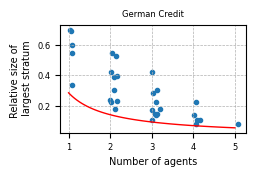

In [65]:
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.scatter(xs2, ys2)
plt.plot(reg_xs, reg_ys, color='red')
plt.xlabel('Number of agents')
plt.ylabel('Relative size of \n largest stratum')
plt.title('German Credit')

plot_name = 'gc_largest_stratum_ma.pdf'
# plt.savefig(f'/home/dhasade/audits/ml-audits/results/ECAI/plots/{plot_name}', bbox_inches='tight', dpi=300)